In [1]:


import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import DataConversionWarning
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')




In [2]:
df=pd.read_csv('data\Train.csv')
df_test = pd.read_csv('data\Test.csv')

In [ ]:
df.head()

In [ ]:
df['DATOP'].unique()


In [ ]:
df.info()


In [ ]:
df.shape


In [ ]:
df['target'].mean()


In [ ]:
# # df[['DATOP', 'STD', 'STA']]
df['STD'] =  pd.to_datetime(df['STD'], format='%Y-%m-%d %H:%M:%S')
df['STA'] =  pd.to_datetime(df['STA'], format='%Y-%m-%d %H.%M.%S')
df['DATOP'] =  pd.to_datetime(df['DATOP'], format='%Y-%m-%d')

df_test['STD'] =  pd.to_datetime(df_test['STD'], format='%Y-%m-%d %H:%M:%S')
df_test['STA'] =  pd.to_datetime(df_test['STA'], format='%Y-%m-%d %H.%M.%S')
df_test['DATOP'] =  pd.to_datetime(df_test['DATOP'], format='%Y-%m-%d')

In [ ]:
# there is a space after the flight id
df['FLTID'] = df['FLTID'].astype(str).str[:-1]
df_test['FLTID'] = df_test['FLTID'].astype(str).str[:-1]

In [ ]:
df['FLTID'][0]


In [ ]:
df['STATUS'].unique()


In [ ]:
df.isnull().sum(axis=0).reset_index()


In [ ]:
df['AC'].unique()


In [ ]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['target'].groupby(df['AC']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

In [3]:
X = df.drop(['target'], axis=1)
y = df[['target']].values

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting Train-set and Test-set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting Train-set and Validation-set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [ ]:
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)


In [ ]:
#Choosing the evaluation metric
# Formula to get accuracy
def get_accuracy(y_true, y_preds):
    # Getting score of confusion matrix
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_preds).ravel()
    # Calculating accuracy
    accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
    return accuracy

In [ ]:
#Creating some baseline models
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

#Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#Random Forest Classifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

#KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

In [ ]:
#Evaluation of accuracy on validation dataset
models = [lr, gnb, rf, knn]
acc = []
for model in models:
    preds_val = model.predict(X_val)
    accuracy = get_accuracy(y_val, preds_val)
    acc.append(accuracy)
model_name = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'KNN']
accuracy = dict(zip(model_name, acc))
plt.figure(figsize=(15,5))
ax = sns.barplot(x = list(accuracy.keys()), y = list(accuracy.values()))
for p, value in zip(ax.patches, list(accuracy.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create and fit the models
lr = LogisticRegression(random_state=0).fit(X_train, y_train)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
linreg = LinearRegression()
linreg.fit(X_train, y_train)  # Assuming X_train, y_train are available

# List of models
models = [lr, gnb, rf, knn, linreg]
model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'KNN', 'Linear Regression']

# Scoring metrics
scoring_metrics = {'accuracy': accuracy_score, 'mse': mean_squared_error, 'r2': r2_score}

# Cross-validation and validation accuracy
cv_results = {}
validation_results = {}
for metric_name, scoring_func in scoring_metrics.items():
    cv_scores = []
    validation_scores = []
    for model in models:
        # Cross-validation
        cv_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring=scoring_func)))
        
        # Validation accuracy
        preds_val = model.predict(X_val)
        validation_scores.append(scoring_func(y_val, preds_val))
    
    cv_results[metric_name] = cv_scores
    validation_results[metric_name] = validation_scores

# Plotting
for metric_name in scoring_metrics.keys():
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=model_names, y=validation_results[metric_name])
    for p, value in zip(ax.patches, validation_results[metric_name]):
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + 0.008
        ax.text(_x, _y, round(value, 3), ha="center")
    plt.xlabel("Models")
    plt.ylabel(metric_name.capitalize())
    plt.title(f"Model vs. {metric_name.capitalize()}")
    plt.xticks(rotation=45)
    plt.show()


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:

# Importing airports data and saving it to a csv file
import airportsdata
airports = airportsdata.load('IATA')

# Filling the missing the airport information for SXF with the data of BER
airports['SXF'] = {'icao': 'EDDB',
 'iata': 'SXF',
 'name': 'Berlin Schonefeld Airport',
 'city': 'Berlin',
 'subd': 'Brandenburg',
 'country': 'DE',
 'elevation': 156.0,
 'lat': 52.362167,
 'lon': 13.500667,
 'tz': 'Europe/Berlin',
 'lid': ''}

airports_df = pd.DataFrame(airports).T
airports_df.to_csv('data/airportdata.csv', index=True)

In [6]:

# Import flight data and airport data
df_flightdata = pd.read_csv('data/Train.csv')
df_airportdata = pd.read_csv('data/airportdata.csv',index_col=0)

# # Converting to the right datatype
df_flightdata['STA'] = pd.to_datetime(df_flightdata['STA'], format='%Y-%m-%d %H.%M.%S')
df_flightdata['STD'] = pd.to_datetime(df_flightdata['STD'], format='%Y-%m-%d %H:%M:%S')
#df_flightdata['DATOP'] = pd.to_datetime(df_flightdata['DATOP'], format='%Y-%m-%d')
###############################################################################################################
df_flightdata['DATOP'] = pd.to_datetime(df_flightdata['DATOP'], format='%Y-%m-%d')

# Extract year, month, and day components
df_flightdata['year'] = df_flightdata['DATOP'].dt.year
df_flightdata['month'] = df_flightdata['DATOP'].dt.month
df_flightdata['day'] = df_flightdata['DATOP'].dt.day

# Print the modified DataFrame
df_flightdata

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,year,month,day
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,2016,1,3
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,2016,1,13
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,2016,1,16
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,2016,1,17
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,2016,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,SCH,TU 32AIML,0.0,2018,7,5
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,SCH,UG AT7AT7,0.0,2018,1,13
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,SCH,TU 736IOK,0.0,2018,11,7
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,ATA,TU CR9ISA,0.0,2018,1,23


In [7]:
# Merge df with departure airport data
df = df_flightdata.join(df_airportdata[['iata', 'country', 'elevation', 'lat', 'lon']].add_prefix('dep_'), how='left', on='DEPSTN')
df = df.join(df_airportdata[['iata', 'country', 'elevation', 'lat', 'lon']].add_prefix('arr_'), how='left', on='ARRSTN')
# Merge df with arrival airport data
display(df.head().T)

,0,1,2,3,4
ID,train_id_0,train_id_1,train_id_2,train_id_3,train_id_4
DATOP,2016-01-03 00:00:00,2016-01-13 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00
FLTID,TU 0712,TU 0757,TU 0214,TU 0480,TU 0338
DEPSTN,CMN,MXP,TUN,DJE,TUN
ARRSTN,TUN,TUN,IST,NTE,ALG
STD,2016-01-03 10:30:00,2016-01-13 15:05:00,2016-01-16 04:10:00,2016-01-17 14:10:00,2016-01-17 14:30:00
STA,2016-01-03 12:55:00,2016-01-13 16:55:00,2016-01-16 06:45:00,2016-01-17 17:00:00,2016-01-17 15:50:00
STATUS,ATA,ATA,ATA,ATA,ATA
AC,TU 32AIMN,TU 31BIMO,TU 32AIMN,TU 736IOK,TU 320IMU
target,260.0,20.0,0.0,0.0,22.0


In [8]:
# you must make the dataset equal to the function
# i.e. df = del_duplicates(df)
def del_duplicates(input_dataset):
    # check for duplicates 
    print(input_dataset.duplicated().value_counts())
    # remove duplicates
    input_dataset = input_dataset.drop_duplicates()
    # reset index inplace
    input_dataset.reset_index(inplace=True, drop=True)
    return input_dataset
    
df = del_duplicates(df)

False    107833
Name: count, dtype: int64


In [9]:
# which are statistical continous values?
# which are statistical quantitative values?


# check the different columns
# is a column a unique identifier? 
# can it be dropped to a unique identifier table, 
# i.e. unique identifier and then name, address, ticket number etc. (info table)
# postcode/zipcode an example of a none unique identifier, things that can't be grouped
df.dtypes

def table_nuniques(input_dataset):
    nunique_dictionary = {'column name': [], 'nuniques': [], 'uniques':[], 'dtype' : []}
    infun_data = input_dataset
    columnlist = list(infun_data.columns)
    for i in columnlist: 
        nunique_dictionary['column name'].append(i)
        nunique_dictionary['nuniques'].append(infun_data[i].nunique())        
        nunique_dictionary['uniques'].append(infun_data[i].unique())
        nunique_dictionary['dtype'].append(infun_data[i].dtype)
    # print the dictionary as a dataframe
    return pd.DataFrame(nunique_dictionary)

table_nuniques(df)

,column name,nuniques,uniques,dtype
0,ID,107833,"[train_id_0, train_id_1, train_id_2, train_id_...",object
1,DATOP,1011,"[2016-01-03 00:00:00, 2016-01-13 00:00:00, 201...",datetime64[ns]
2,FLTID,1861,"[TU 0712 , TU 0757 , TU 0214 , TU 0480 , TU 03...",object
3,DEPSTN,132,"[CMN, MXP, TUN, DJE, TLS, IST, ORY, MIR, BRU, ...",object
4,ARRSTN,128,"[TUN, IST, NTE, ALG, BCN, ORY, FCO, NCE, MRS, ...",object
5,STD,81697,"[2016-01-03 10:30:00, 2016-01-13 15:05:00, 201...",datetime64[ns]
6,STA,85136,"[2016-01-03 12:55:00, 2016-01-13 16:55:00, 201...",datetime64[ns]
7,STATUS,5,"[ATA, DEP, RTR, SCH, DEL]",object
8,AC,68,"[TU 32AIMN, TU 31BIMO, TU 736IOK, TU 320IMU, T...",object
9,target,968,"[260.0, 20.0, 0.0, 22.0, 53.0, 10.0, 15.0, 16....",float64


In [10]:
# FIX COLUMN NAMES Function - general function build out with time
def fix_column_names(input_dataset):
    infun_data = input_dataset
    # pull the starting columns to show at the end the transformation 
    starting_columns = list(infun_data.columns)
    # carry out the changes; remove spaces and hyphens, lower case everything
    infun_data.columns = infun_data.columns.str.replace(' ','_')
    infun_data.columns = infun_data.columns.str.lower()
    infun_data.columns = infun_data.columns.str.replace('-', '_')
    # pull the ending columns to show at the end the transformation 
    ending_columns = list(infun_data.columns)
    # create a dictionary of the old names vs the new names 
    dict_of_names = {'old column name': starting_columns, 'new column name': ending_columns}
    dataframe_of_column_names = df = pd.DataFrame(dict_of_names) 
    print(dataframe_of_column_names)
    return infun_data

df = fix_column_names(df)

   old column name new column name
0               ID              id
1            DATOP           datop
2            FLTID           fltid
3           DEPSTN          depstn
4           ARRSTN          arrstn
5              STD             std
6              STA             sta
7           STATUS          status
8               AC              ac
9           target          target
10            year            year
11           month           month
12             day             day
13        dep_iata        dep_iata
14     dep_country     dep_country
15   dep_elevation   dep_elevation
16         dep_lat         dep_lat
17         dep_lon         dep_lon
18        arr_iata        arr_iata
19     arr_country     arr_country
20   arr_elevation   arr_elevation
21         arr_lat         arr_lat
22         arr_lon         arr_lon


In [11]:
#  no na was found!!
print("Null values")
print(df.isnull().sum())
print("="*50)
print("Zero values")
print((df == 0).sum())

Null values
id               0
datop            0
fltid            0
depstn           0
arrstn           0
std              0
sta              0
status           0
ac               0
target           0
year             0
month            0
day              0
dep_iata         0
dep_country      0
dep_elevation    0
dep_lat          0
dep_lon          0
arr_iata         0
arr_country      0
arr_elevation    0
arr_lat          0
arr_lon          0
dtype: int64
Zero values
id                   0
datop                0
fltid                0
depstn               0
arrstn               0
std                  0
sta                  0
status               0
ac                   0
target           38168
year                 0
month                0
day                  0
dep_iata             0
dep_country          0
dep_elevation        0
dep_lat              0
dep_lon              0
arr_iata             0
arr_country          0
arr_elevation        0
arr_lat              0
arr_lon             

In [12]:
# Feature engineering

# Airline names
df['airline_code'] = df['fltid'].str[:2]

# Elevation difference
df['elevation_dif'] = (df['arr_elevation'] - df['dep_elevation'])

# Flight time in minutes
df['flight_time_in_min'] = (df['sta'] - df['std']).dt.total_seconds() / 60

In [13]:
from geopy.distance import geodesic


In [14]:
# Distance between departure and arrival airports using the library geodesic
def calculate_distance(row):
    dep_coords = (row['dep_lat'], row['dep_lon'])
    arr_coords = (row['arr_lat'], row['arr_lon'])
    distance = geodesic(dep_coords, arr_coords).kilometers
    return int(round(distance,0))

df['flight_distance_in_km'] = df.apply(calculate_distance, axis=1)

In [15]:
df['flight_distance_in_km']

0         1667
1          983
2         1673
3         1805
4          626
          ... 
107828       0
107829     334
107830       0
107831     334
107832     334
Name: flight_distance_in_km, Length: 107833, dtype: int64

In [16]:
df['average_flight_speed_km_h'] = (df['flight_distance_in_km']*60/df['flight_time_in_min'])
df['average_flight_speed_km_h'] = df['average_flight_speed_km_h'].round().astype(int)


In [17]:
df['international_flight'] = np.where(df['arr_country'] != df['dep_country'], 1, 0)

In [18]:
df['international_flight'].value_counts()

international_flight
1    88932
0    18901
Name: count, dtype: int64

In [19]:
df['std'] = df['std'].dt.time
df['sta'] = df['sta'].dt.time

In [20]:

# Import flight data and airport data
df_flightdata = pd.read_csv('data/Train.csv')
df_airportdata = pd.read_csv('data/airportdata.csv',index_col=0)

# # Converting to the right datatype
df_flightdata['STA'] = pd.to_datetime(df_flightdata['STA'], format='%Y-%m-%d %H.%M.%S')
df_flightdata['STD'] = pd.to_datetime(df_flightdata['STD'], format='%Y-%m-%d %H:%M:%S')
#df_flightdata['DATOP'] = pd.to_datetime(df_flightdata['DATOP'], format='%Y-%m-%d')
###############################################################################################################
df_flightdata['DATOP'] = pd.to_datetime(df_flightdata['DATOP'], format='%Y-%m-%d')

# Extract year, month, and day components
df_flightdata['year'] = df_flightdata['DATOP'].dt.year
df_flightdata['month'] = df_flightdata['DATOP'].dt.month
df_flightdata['day'] = df_flightdata['DATOP'].dt.day

# Print the modified DataFrame
df_flightdata

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,year,month,day
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,2016,1,3
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,2016,1,13
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,2016,1,16
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,2016,1,17
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,2016,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,SCH,TU 32AIML,0.0,2018,7,5
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,SCH,UG AT7AT7,0.0,2018,1,13
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,SCH,TU 736IOK,0.0,2018,11,7
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,ATA,TU CR9ISA,0.0,2018,1,23


In [21]:


# Create the seasons column
df.loc[(df['month'] < 3) | (df['month'] == 12), 'season'] = 'winter'
df.loc[(df['month'] >= 3) & (df['month'] < 6), 'season'] = 'spring' 
df.loc[(df['month'] >= 6) & (df['month'] < 9), 'season'] = 'summer' 
df.loc[(df['month'] >= 9) & (df['month'] < 12), 'season'] = 'autumn'

# Print the modified DataFrame
df.T

,0,1,2,3,4,5,6,7,8,9,...,107823,107824,107825,107826,107827,107828,107829,107830,107831,107832
id,train_id_0,train_id_1,train_id_2,train_id_3,train_id_4,train_id_5,train_id_6,train_id_7,train_id_8,train_id_9,...,train_id_107823,train_id_107824,train_id_107825,train_id_107826,train_id_107827,train_id_107828,train_id_107829,train_id_107830,train_id_107831,train_id_107832
datop,2016-01-03 00:00:00,2016-01-13 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-18 00:00:00,2016-01-18 00:00:00,2016-01-18 00:00:00,...,2018-04-12 00:00:00,2018-02-09 00:00:00,2018-08-08 00:00:00,2018-10-15 00:00:00,2018-12-19 00:00:00,2018-07-05 00:00:00,2018-01-13 00:00:00,2018-11-07 00:00:00,2018-01-23 00:00:00,2018-11-13 00:00:00
fltid,TU 0712,TU 0757,TU 0214,TU 0480,TU 0338,TU 0283,TU 0514,TU 0716,TU 0752,TU 0996,...,TU 9001,UG 1730,WKL 0000,UG 0011,SGT 0000,WKL 0000,UG 0003,SGT 0000,UG 0010,UG 0002
depstn,CMN,MXP,TUN,DJE,TUN,TLS,TUN,TUN,TUN,TUN,...,MIR,TUN,TUN,DJE,TUN,TUN,DJE,TUN,TUN,TUN
arrstn,TUN,TUN,IST,NTE,ALG,TUN,BCN,ORY,FCO,NCE,...,TUN,NAP,TUN,TUN,TUN,TUN,TUN,TUN,DJE,DJE
std,10:30:00,15:05:00,04:10:00,14:10:00,14:30:00,16:20:00,07:15:00,07:35:00,07:40:00,07:45:00,...,17:05:00,10:00:00,22:00:00,19:45:00,23:45:00,23:00:00,08:00:00,05:00:00,18:00:00,06:15:00
sta,12:55:00,16:55:00,06:45:00,17:00:00,15:50:00,18:15:00,09:00:00,09:55:00,09:00:00,09:15:00,...,17:40:00,11:15:00,01:00:00,20:45:00,01:45:00,02:00:00,09:00:00,12:50:00,18:45:00,07:05:00
status,ATA,ATA,ATA,ATA,ATA,ATA,ATA,ATA,ATA,ATA,...,ATA,SCH,SCH,SCH,SCH,SCH,SCH,SCH,ATA,SCH
ac,TU 32AIMN,TU 31BIMO,TU 32AIMN,TU 736IOK,TU 320IMU,TU 736IOP,TU 32AIMH,TU 32AIMI,TU 32AIMC,TU 31AIMK,...,TU 736IOL,TU CR9ISA,TU 320IMV,UG AT7LBE,TU 736IOP,TU 32AIML,UG AT7AT7,TU 736IOK,TU CR9ISA,TU CR9ISA
target,260.0,20.0,0.0,0.0,22.0,53.0,10.0,15.0,16.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   id                         107833 non-null  object        
 1   datop                      107833 non-null  datetime64[ns]
 2   fltid                      107833 non-null  object        
 3   depstn                     107833 non-null  object        
 4   arrstn                     107833 non-null  object        
 5   std                        107833 non-null  object        
 6   sta                        107833 non-null  object        
 7   status                     107833 non-null  object        
 8   ac                         107833 non-null  object        
 9   target                     107833 non-null  float64       
 10  year                       107833 non-null  int32         
 11  month                      107833 non-null  int32   

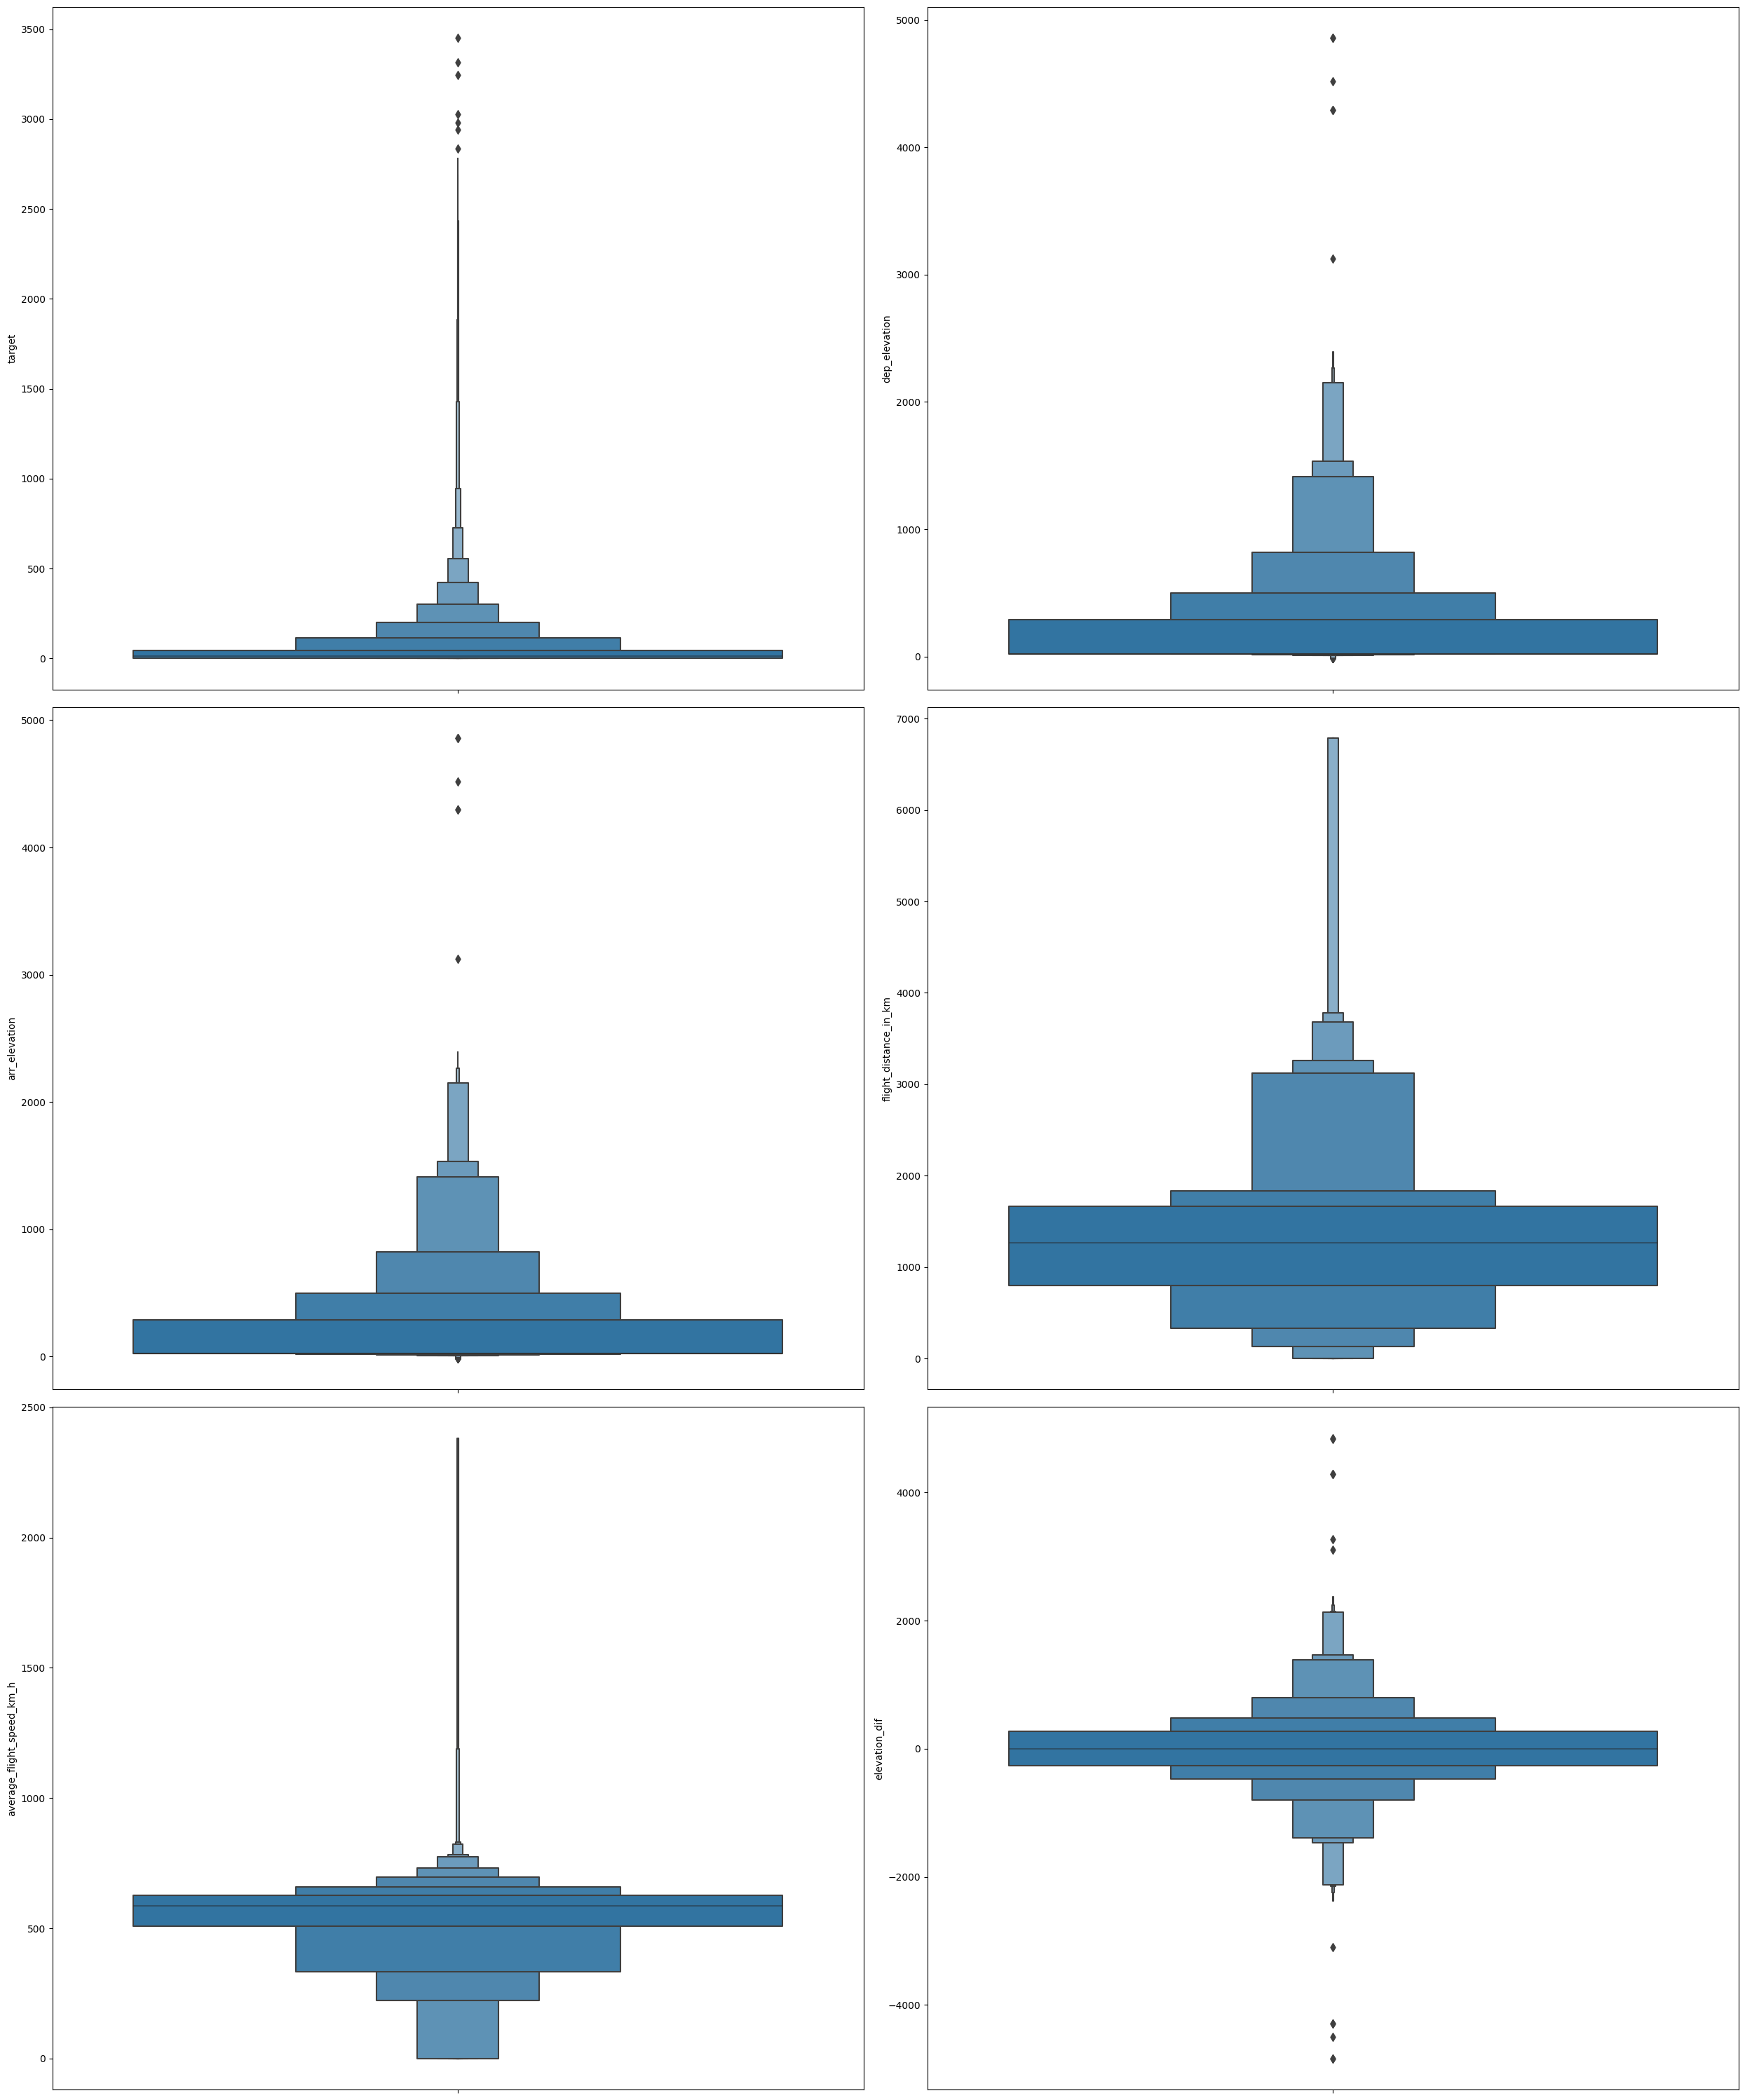

In [53]:
# catoriring 
numerical_columns   = ['target','dep_elevation','arr_elevation','flight_distance_in_km','average_flight_speed_km_h','elevation_dif']
categorical_columns = ['dep_country','id','year','month','day','fltid','depstn','arrstn','status','ac','dep_iata','arr_iata','arr_country','std','sta','season']
numerical_features   = df[numerical_columns]
categorical_features = df[categorical_columns]
#Univariate Analysis¶

fig = plt.figure(figsize=(25,40))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(4,2,i+1)
    sns.boxenplot( y=numerical_features.iloc[:,i])

plt.tight_layout()
plt.show()

In [125]:
X = df.drop(['target','id'], axis=1)
y = df[['target']]

In [126]:
# Splitting Train-set and Test-set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting Train-set and Validation-set


In [127]:
# Convert timestamps to numeric features
X_train['year'] = X_train['datop'].dt.year
X_train['month'] = X_train['datop'].dt.month
X_train['day'] = X_train['datop'].dt.day
X_train['hour'] = X_train['datop'].dt.hour
X_train['minute'] = X_train['datop'].dt.minute

# Drop the original timestamp column
X_train = X_train.drop(columns=['datop'])

In [128]:
len(df['id'].value_counts())

107833

In [129]:
categorical_columns = ['dep_country','year','month','day','fltid','depstn','arrstn','status','ac','dep_iata','arr_iata','arr_country','std','sta','season','airline_code']


In [130]:
# Assuming X_train is a pandas DataFrame with categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)

# Continue with model fitting using X_train_encoded


In [131]:
X_train_encoded.columns[X_train_encoded.dtypes == "object"]



Index([], dtype='object')

In [132]:
df.head().T

,0,1,2,3,4
id,train_id_0,train_id_1,train_id_2,train_id_3,train_id_4
datop,2016-01-03 00:00:00,2016-01-13 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-17 00:00:00
fltid,TU 0712,TU 0757,TU 0214,TU 0480,TU 0338
depstn,CMN,MXP,TUN,DJE,TUN
arrstn,TUN,TUN,IST,NTE,ALG
std,10:30:00,15:05:00,04:10:00,14:10:00,14:30:00
sta,12:55:00,16:55:00,06:45:00,17:00:00,15:50:00
status,ATA,ATA,ATA,ATA,ATA
ac,TU 32AIMN,TU 31BIMO,TU 32AIMN,TU 736IOK,TU 320IMU
target,260.0,20.0,0.0,0.0,22.0


In [133]:
# # catoriring 
# numerical_columns   = ['target','dep_elevation','arr_elevation','flight_distance_in_km','average_flight_speed_km_h','elevation_dif']
# categorical_columns = ['id','fltid','depstn','arrstn','status','ac','dep_iata','arr_iata','arr_country','std','sta','season']

# numerical_features   = df[numerical_columns]
# categorical_features = df[categorical_columns]

In [138]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer


In [141]:


# Create and fit the models
linreg = LinearRegression()
linreg.fit(X_train_encoded, y_train)  # Assuming X_train, y_train are available

# List of models
models = [linreg]
model_names = ['Linear Regression']

# Scoring metrics

# Scoring metrics
scoring_metrics = {
    'r2': 'r2',  # You can use built-in string scorers directly
    'mse': 'neg_mean_squared_error',  # Using negative MSE because cross_val_score uses a maximizing strategy
    'rmse': 'neg_root_mean_squared_error',  # Using negative RMSE for the same reason
    'mape': make_scorer(mean_absolute_percentage_error)
}
# Cross-validation and validation scores
cv_results = {}
validation_results = {}
for metric_name, scoring_func in scoring_metrics.items():
    cv_scores = []
    validation_scores = []
    for model in models:
        # Cross-validation
        cv_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring=scoring_func)))
        
        # Validation score
        preds_val = model.predict(X_val)
        validation_scores.append(scoring_func(y_val, preds_val))
    
    cv_results[metric_name] = cv_scores
    validation_results[metric_name] = validation_scores

# Plotting
for metric_name in scoring_metrics.keys():
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=model_names, y=validation_results[metric_name])
    for p, value in zip(ax.patches, validation_results[metric_name]):
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + 0.008
        ax.text(_x, _y, round(value, 3), ha="center")
    plt.xlabel("Model")
    plt.ylabel(metric_name.upper())
    plt.title(f"Model vs. {metric_name.upper()}")
    plt.xticks(rotation=45)
    plt.show()


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\linear_model\_base.py", line 648, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\pandas\core\generic.py", line 1998, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'TU 0339 '

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\linear_model\_base.py", line 648, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sa3id\spiced\flight_delays_ML\.venv\Lib\site-packages\pandas\core\generic.py", line 1998, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'UG 0047 '


In [65]:
# Calculating the accuracy for the LogisticRegression Classifier
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {:.2f}".format(r2_score(y_test, y_pred)))
print("Precision: {:.2f}".format(mean_squared_error(y_test, y_pred)))

Cross validation scores:
-------------------------


NameError: name 'y_pred' is not defined